In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

warnings.filterwarnings('ignore')


# Excerise 3
In this exercise you will explore two ways of dealing with overfitting --- the first, model selection (one that you have explored before), and the second, regularization.
For this we will use synthetic data and try to fit a polynomial to this data using regression.

This is a rather short exercise, but will require self learning and exploring.

## Creating the Data
Run the following code to create the data. This creates a synthetic dataset by adding some random Gaussian noise to a sinusoidal function. Note we used a specific seed so that the generated data would be identical in all runs.

Note: in this exercise you should **use the test set as a validation set**, as we will not care about reporting an approximation for the generalization error of our model.

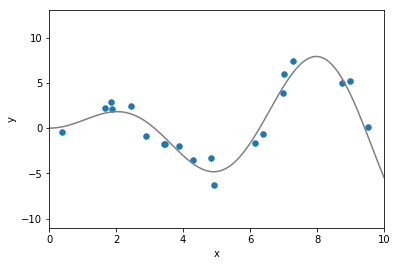

In [2]:
def f(x):
    return x * np.sin(x)

def plot_fit(ax, X_train=None, y_train=None, model=None, label=None):
    min_x, max_x = np.floor(min(X_train)), np.ceil(max(X_train))
    x_range = np.linspace(min_x, max_x, 100)
    y = f(x_range)
    min_y, max_y = np.floor(min(y))-5, np.ceil(max(y))+5
    ax.plot(x_range, y, color='gray')
    if X_train is not None and y_train is not None:
        ax.scatter(X_train, y_train, s=30)
    if model is not None:
        ax.plot(x_range, model.predict(x_range[:, np.newaxis]), color='red', label=label)
    ax.set_ylim((min_y, max_y))
    ax.set_xlim((min_x, max_x))
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    if label is not None:
        ax.legend(loc='upper right')

def create_data(n_samples = 100, test_size=0.8, min_x=0, max_x=10, err_scale=1):
    np.random.seed(9)
    X = np.random.uniform(min_x, max_x, size=n_samples)[:, np.newaxis]
    S = np.random.normal(loc=0, scale=err_scale, size=n_samples)[:, np.newaxis] # loc is mean, and scale is std
    y = f(X) + S
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)
    return X_train, X_test, y_train, y_test

# generate data
X_train, X_test, y_train, y_test = create_data()
plot_fit(plt.gca(), X_train, y_train)

## Polynomial Regression - Model Selection
Apply polynomial regression to the data, using polynomials with maximal degree of 0 to 11. 

- Plot the fitted polynomial against the trainning data and the underlying generating function (that is, for each fitted polynomial, plot that polynomial on top of a graph similar to the one plotted above).
- Do you see underfitting or overfitting? Which is the best degree for this model?
- Apply model selection technique for choosing the best polynomial degree hyperparameter. Explain your results.

### Answer
From degrees 0 to 3, the model is clearly underfitting the ground truth, as the polynomial curve has a very different shape from the grey curve, and is absolutely not aligned with it.

From degrees 4 to 6, there is a very nice fit, with degree 6 being the most in line with the ground truth.

From degrees 7 and onwards, we start to see overfitting and it becomes very visible in the largest degrees, where the red curves seem to be trying to 'catch' as many blue points as possible rather than producing a model that is immune to noise in the underlying data.

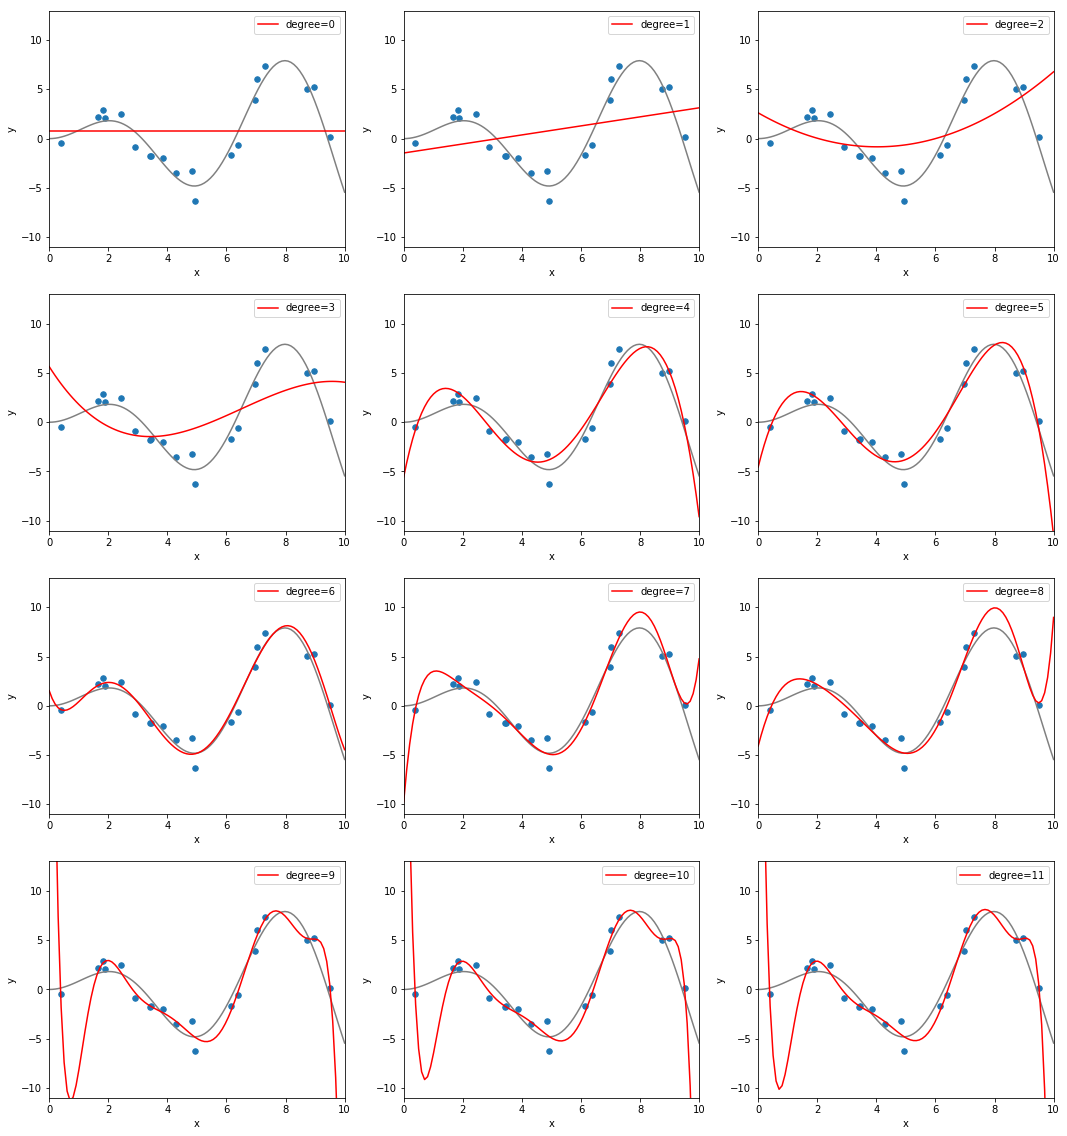

In [3]:
models_by_degrees = []
plt.subplots(4,3, figsize=(18, 20))
for deg in range(0, 12):
    model = Pipeline([('poly', PolynomialFeatures(degree=deg)), 
                      ('linear', LinearRegression(fit_intercept=False))])
    model.fit(X_train, y_train)
    models_by_degrees.append(model)

    plt.subplot(4, 3, deg+1)
    plot_fit(plt.gca(), X_train, y_train, model=model, label='degree=%d' % deg)
plt.show()

In [4]:
for idx, model in enumerate(models_by_degrees):
    print('%d-degree polynomial R² score: %.2f' % (idx, r2_score(y_test, model.predict(X_test))))

0-degree polynomial R² score: -0.00
1-degree polynomial R² score: 0.02
2-degree polynomial R² score: 0.14
3-degree polynomial R² score: 0.22
4-degree polynomial R² score: 0.85
5-degree polynomial R² score: 0.86
6-degree polynomial R² score: 0.93
7-degree polynomial R² score: 0.83
8-degree polynomial R² score: 0.84
9-degree polynomial R² score: -1.48
10-degree polynomial R² score: -0.84
11-degree polynomial R² score: -1.28


The 6-degree polynomial regression returns the highest R² score, indicating this is our model of choice, and confirming our initial intuition when we looked at the various regression plots.

## Polynomial Regression - Regularization
Now, instead of choosing the best maximal degree to use, we will use polynomial regression with regularization. 

- Apply polynomial ridge regression with polynomial degree 11, using different regularization parameters (also test the case where the regularization parameter equals 0). For this task you should use L2-norm regularization (ridge regression), which uses the sum of squared parameters as the regularization term (as we saw in class). That is, 
$$
L(\boldsymbol\theta) = \frac{1}{n}\sum_{i=0}^n (y_i – \boldsymbol\theta^T \mathbf{x}_i)^2 + \alpha \|\boldsymbol\theta\|_2
$$
where $\alpha$ is the regularization parameter, $\boldsymbol\theta$ is the vector of coefficients including the intercept term and $\mathbf{x}_i$ is the vector of the predictors of the i-th data point including a constant predictor for the intercept.

>Again, plot the fitted polynomial against the trainning data and the underlying generating function. This time, also plot the coefficients of the fitted polynomial. 

- What is the effect of applying regularization to the regression model, with different regularization parameters? What would be the best regularization parameter to use in this case? Compare your results with the model selection approach for overcoming the the problem of overfitting.

- Compare the above results with L1-norm regularization (LASSO) instead of the L2-norm, that is
$$
L(\boldsymbol\theta) = \frac{1}{n}\sum_{i=0}^n (y_i – \boldsymbol\theta^T \mathbf{x}_i)^2 + \alpha \|\boldsymbol\theta\|_1
$$

### Answer
- Applying regularization to a high degree polynomial regression (overfitted) was able to reduce the overfitting effect. For alpha values > 0.001, the regression actually becomes underfitting. We can see from the coefficient plots that the effect of regularization is to cancel the higher degree elements of the polynomial.
- The LASSO regularization seems to cancel the higher degree polynomial more quickly, generally resulting in a poorer fit than its ridge counterpart

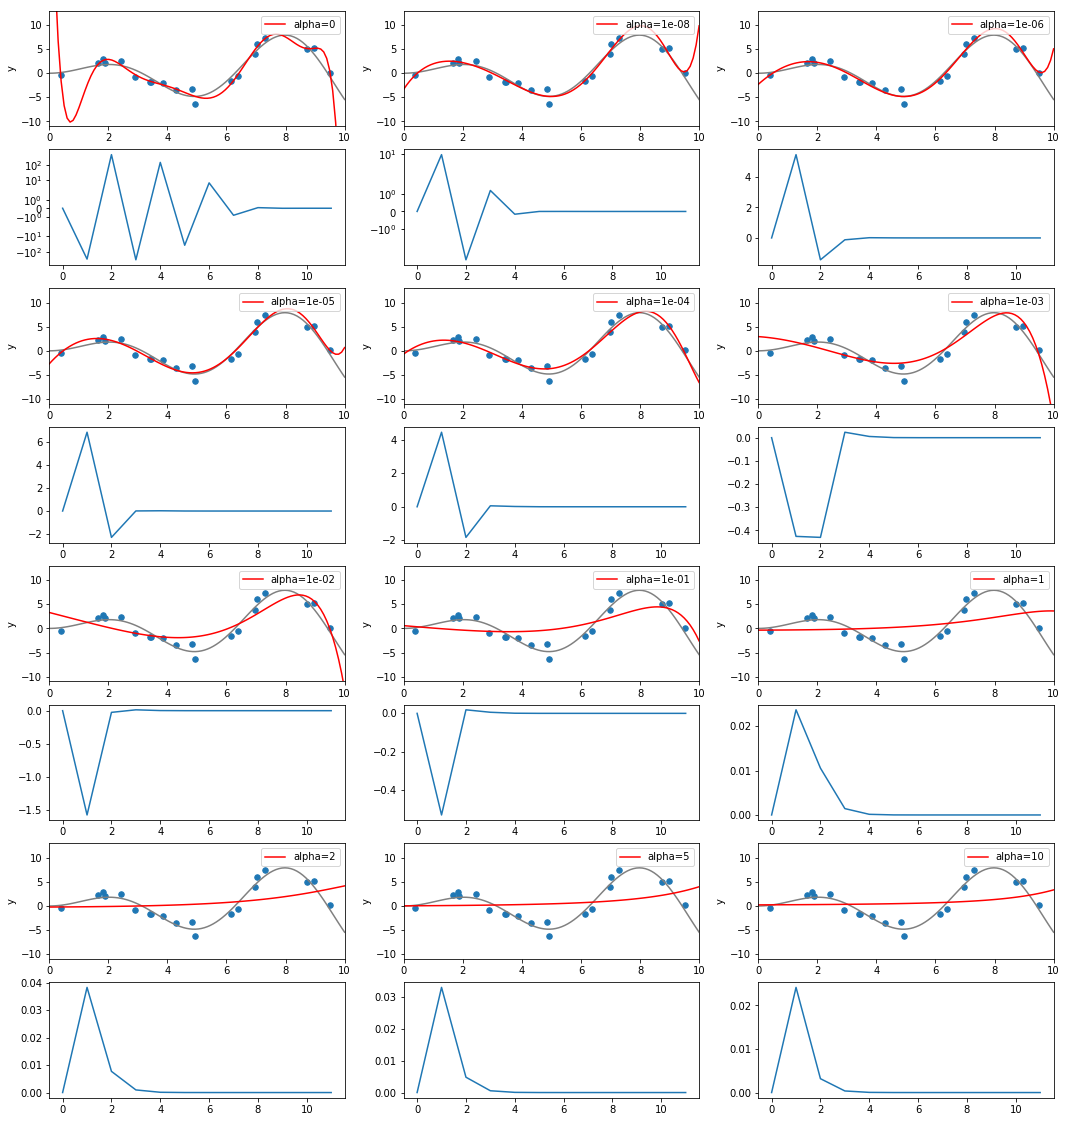

In [9]:
#Set the different values of alpha to be tested
alpha_ridge = [0, 1e-8, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2,0.1, 1, 2, 5, 10]

plt.subplots(8,3, figsize=(18, 20))
for idx, alpha in enumerate(alpha_ridge):
    model = Pipeline([('poly', PolynomialFeatures(degree=11)), 
                      ('ridge', Ridge(alpha=alpha,normalize=True))])
    model.fit(X_train, y_train)
    
    plt.subplot(8, 3, 6 * int(idx / 3) + (idx % 3) + 1)
    plot_fit(plt.gca(), X_train, y_train, model=model, label=('alpha=%.e' % alpha if 0 < alpha < 1 else 'alpha=%d' % alpha))
    plt.subplot(8,3, 6 * int(idx / 3) + (idx % 3) + 4)
    plt.yscale('symlog') if idx < 2 else None
    plt.plot(range(12), model.named_steps['ridge'].coef_.ravel())
    
plt.show()

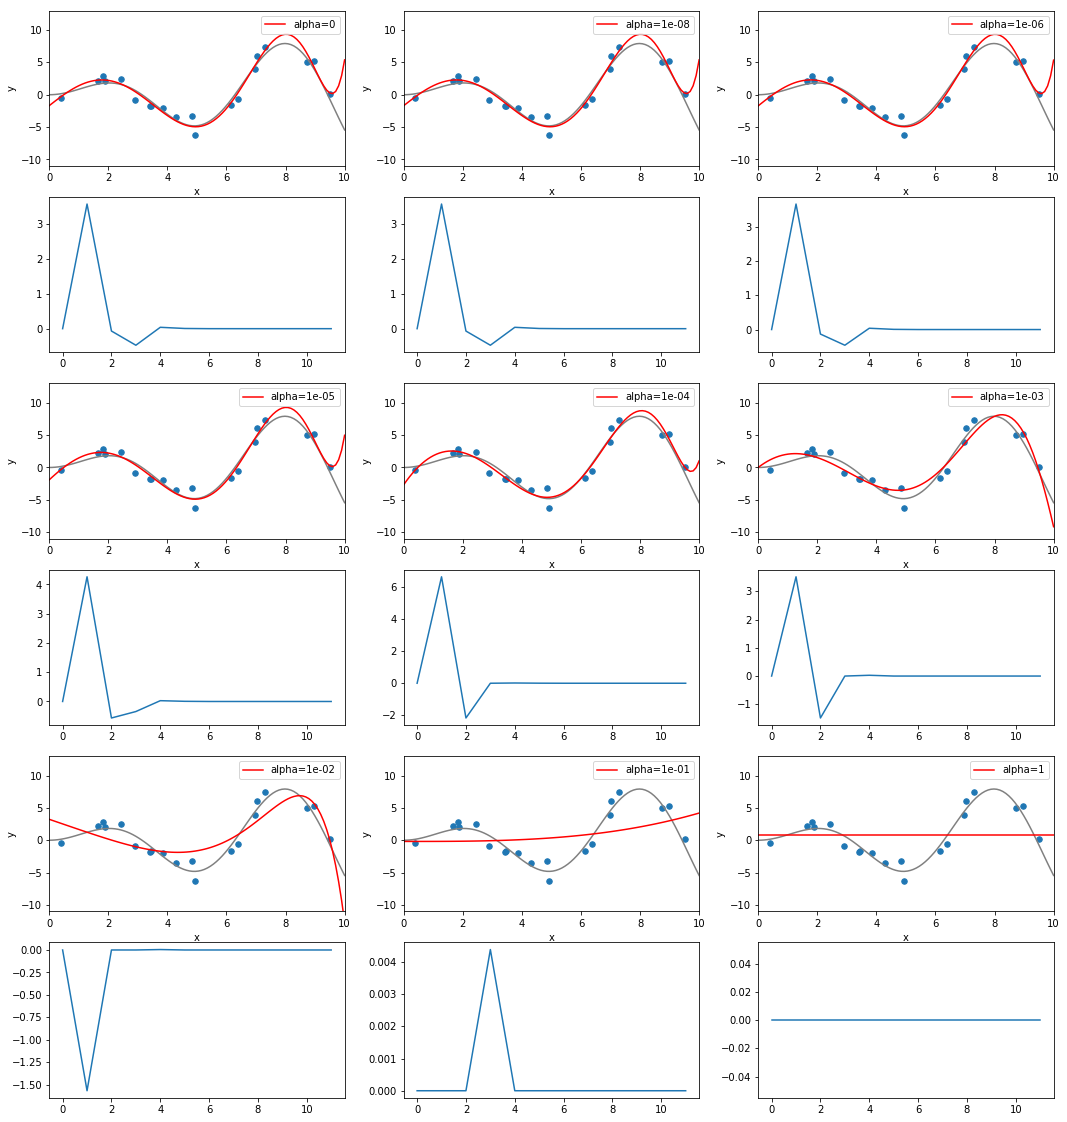

In [7]:
#Set the different values of alpha to be tested
alpha_ridge = [0, 1e-8, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2,0.1, 1]

plt.subplots(6,3, figsize=(18, 20))
for idx, alpha in enumerate(alpha_ridge):
    model = Pipeline([('poly2', PolynomialFeatures(degree=11)), 
                      ('lasso', Lasso(alpha=alpha,normalize=True, max_iter=1e6))])
    model.fit(X_train, y_train)
    
    plt.subplot(6, 3, 6 * int(idx / 3) + (idx % 3) + 1)
    plot_fit(plt.gca(), X_train, y_train, model=model, label=('alpha=%.e' % alpha if 0 < abs(alpha) < 1 else 'alpha=%d' % alpha))
    plt.subplot(6,3, 6 * int(idx / 3) + (idx % 3) + 4)
    plt.plot(range(12), model.named_steps['lasso'].coef_.ravel())
    
plt.show()